## <center>Exercises 7: Monte Carlo simulation with Metropolis algorithm</center>

In this notebook we are going to simulate the behaviour of an Argon sample in solid, liquid and gas phase under the action of a Lennard-Jones potential, that is 
$$V_{LJ} = 4 \epsilon \left[\left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6\right]$$
in reduced units ($\sigma=\epsilon=1$).

<br /> We are using the Metropolis algorithm for simulating molecular dynamics, a Monte Carlo tecnique: at each Monte Carlo step we randomly select a particle and then decide whether or not to move it according to a probability distribution, which in our case is the Boltzmann weight. 
<br /> The approximations used are the following:
- considering space as an infinite lattice composed by identical boxes, a symmetry which almost doesn't affect molecules of a system with a short range potential as Lennard-Jones; when a molecule passes from a box to the next one its image enters the first box from the opposite side, so the system has no walls (periodic boundary conditions)
- a molecule only interacts with molecules (or images) inside a region equal in size to the box and centered in the molecule itself (minimum image convention)
- applying a spherical cut-off to the potential, which means ignoring all interactions beyond the cut-off distance $r_c$; for sufficiently large $r_c$ and short range potentials this does not imply consistent perturbations

<br> The thermodynamic conditions of the system in the three phases we will work on are the following:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

<br /> The code employed in these exercises is the same MD/MC code used in the Exercises 4. Here we are also adding tail corrections to the estimation of potential energy and pressure: these corrections are a way of compensating the error made ignoring all interactions beyond the cut-off distance $r_c$.

In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Exercise 2

After adding the tail corrections in the code (Exercise 1, only c++ code), we want to find the best simulation parameters for our studies. Namely, we now aim at computing the autocorrelation of the potential energy per particle in order to choose a suitable length for the blocks in data blocking. We will also compute the statistical uncertainty of the potential energy per particle and see how it looks like depending on the length of the blocks.

First of all, for all three phases the system is prepared in the same crystalline configuration and needs some steps to reach equilibrium before simulating its behaviour and measuring properties. During the equilibration phase we are going to plot the average of potential energy in each block in order to monitor its fluctuations; when this value seems to stabilize we have reached the equilibrium and can start the simulation. 
<br /> This initial equilibration takes a different amount of time steps according to the phase we are studying: in my simulations I considered $800$ steps for the solid phase, $1300$ steps for the liquid phase and $4000$ steps for the gas phase.
<br /> During equilibration the potential energy grows for solid and liquid phase because the system is evolving from a starting crystalline configuration, which is certainly not the case of any real system: according to its parameters (as density, temperature) the system becomes more disordered until reaching the correct solid, liquid or gaseous state with a potential energy which is higher than its minimum (reached in the crystalline structure); the potential energy for the liquid and the gas phase is higher because it is a more disordered phase compared to the solid phase.

<br /> Here temperature is fixed as a parameter of the simulation and does not change during it: through the Metropolis algorithm we are sampling configurations according to a probability density and not watching particles move as in the Verlet case; therefore kinetic energy (so as temperature) is not involved in our simulation.

<br /> In order to have an average acceptance of $0.5$ we set the $\delta$ of the Metropolis algorithm to $0.115$ for the solid phase, $0.195$ for the liquid phase and $3.2$ for the gas phase (here the acceptance is of approximately $0.65$, as in the gas phase the system has very low density it is less likely to find a significantly different configuration with a Metropolis move).

Below we are computing and showing the trend of the potential energy per particle during the equilibration steps for each phase of the system.

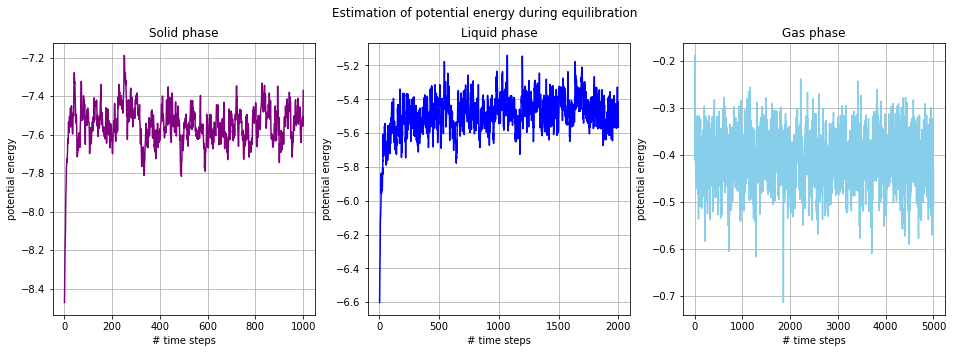

In [3]:
#solid
nstep_s, epot_s = np.loadtxt("./ex_2/Output/Solid/Equilibration/output_epot.dat", usecols=(0,1), delimiter=None, unpack='true')
#liquid
nstep_l, epot_l = np.loadtxt("./ex_2/Output/Liquid/Equilibration/output_epot.dat", usecols=(0,1), delimiter=None, unpack='true')
#gas
nstep_g, epot_g = np.loadtxt("./ex_2/Output/Gas/Equilibration/output_epot.dat", usecols=(0,1), delimiter=None, unpack='true')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Estimation of potential energy during equilibration')

ax1.plot(nstep_s,epot_s,color='purple')
ax1.set_xlabel('# time steps')
ax1.set_ylabel('potential energy')
ax1.set_title('Solid phase')
ax1.grid(True)

ax2.plot(nstep_l,epot_l,color='blue')
ax2.set_xlabel('# time steps')
ax2.set_ylabel('potential energy')
ax2.set_title('Liquid phase')
ax2.grid(True)

ax3.plot(nstep_g,epot_g,color='skyblue')
ax3.set_xlabel('# time steps')
ax3.set_ylabel('potential energy')
ax3.set_title('Gas phase')
ax3.grid(True)

plt.show()

After this initial equilibration, we are going to run a simulation of $M=5\times 10^5$ Monte Carlo steps without using the data blocking tecnique in order to observe the instantaneous evolution of the potential energy per particle $U/N$. We are interested in its fluctuations because we want to find the best length of the blocks we will need for the simulation: we are going to compute the autocorrelation function for $U/N$ and see its dependence on the lag between two sequential measures; these lags are in terms of Monte Carlo steps.
<br /> The autocorrelation function of a quantity $U$ is
$$a(lag) = \frac{\sum_{i=1}^M (U(t_i)-<U>)(U(t_i+lag)-<U>)}{\sum_{i=1}^M (U(t_i)-<U>)^2}$$
which can be seen as
$$a(lag) = \frac{\frac{1}{M}\sum_{i=1}^M (U(t_i)-<U>)(U(t_i+lag)-<U>)}{\sigma_U^2}$$
where $<U>$ is the mean value of $U$ and $\sigma_U^2$ its variance.

In [4]:
def a(data,lag):   #defining autocorrelation function
    
    accu = 0
    M = len(data)
    mean = np.mean(data)
    var = np.var(data)
    data_diff = data - mean
    for i in range(0, (M-1)-lag):
        accu += data_diff[i]*data_diff[i+lag]
    accu /= M
    
    return accu/var

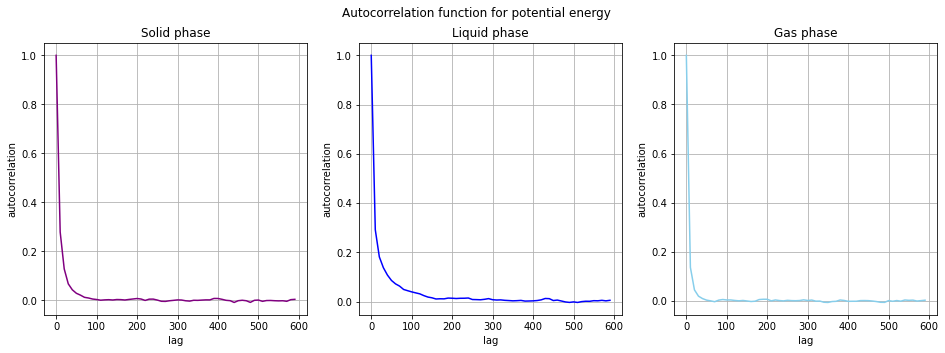

In [5]:
lags = np.arange(0,600,10)

#solid
data_s = np.loadtxt("./ex_2/Output/Solid/Simulation/output_epot.dat", usecols=(1), delimiter=None, unpack='true')
#liquid
data_l = np.loadtxt("./ex_2/Output/Liquid/Simulation/output_epot.dat", usecols=(1), delimiter=None, unpack='true')
#gas
data_g = np.loadtxt("./ex_2/Output/Gas/Simulation/output_epot.dat", usecols=(1), delimiter=None, unpack='true')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Autocorrelation function for potential energy')

ax1.plot(lags,[a(data_s, l) for l in lags],color='purple')
ax1.set_xlabel('lag')
ax1.set_ylabel('autocorrelation')
ax1.set_title('Solid phase')
ax1.grid(True)

ax2.plot(lags,[a(data_l, l) for l in lags],color='blue')
ax2.set_xlabel('lag')
ax2.set_ylabel('autocorrelation')
ax2.set_title('Liquid phase')
ax2.grid(True)

ax3.plot(lags,[a(data_g, l) for l in lags],color='skyblue')
ax3.set_xlabel('lag')
ax3.set_ylabel('autocorrelation')
ax3.set_title('Gas phase')
ax3.grid(True)

plt.show()

Our purpose is finding the best value of lag $t_c$ in order to make autocorrelation negligible. The graphs show a behaviour like 
$$a(t)=e^{-t/t_c}$$ 
that is an adequate trend for an autocorrelation function.
<br> We can fit the data of autocorrelation with this hypothetical behaviour and find the most accurate value of the lag $t_c$: with a lag which is bigger than $2t_c$ we should be sure that the autocorrelation has dropped significantly.

optimized parameter k for solid= [8.6290588]
optimized parameter k for liquid= [10.5317055]
optimized parameter k for gas= [5.1796904]


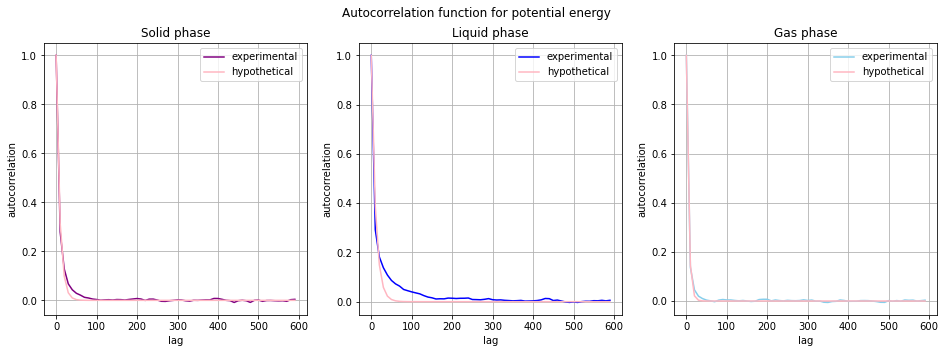

In [11]:
from scipy.optimize import curve_fit

def f(t,k):                            # defining the fitting function
    return np.exp(-t/k)

#solid
p_opt_f_s, p_cov_f_s = curve_fit(f, lags, [a(data_s, l) for l in lags])
a_fit_s = f(lags,p_opt_f_s)
print("optimized parameter k for solid=",p_opt_f_s)

#liquid
p_opt_f_l, p_cov_f_l = curve_fit(f, lags, [a(data_l, l) for l in lags])
a_fit_l = f(lags,p_opt_f_l)
print("optimized parameter k for liquid=",p_opt_f_l)

#gas
p_opt_f_g, p_cov_f_g = curve_fit(f, lags, [a(data_g, l) for l in lags])
a_fit_g = f(lags,p_opt_f_g)
print("optimized parameter k for gas=",p_opt_f_g)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Autocorrelation function for potential energy')

ax1.plot(lags,[a(data_s, l) for l in lags],color='purple',label='experimental')
ax1.plot(lags,a_fit_s,color='lightpink',label='hypothetical')
ax1.set_xlabel('lag')
ax1.set_ylabel('autocorrelation')
ax1.set_title('Solid phase')
ax1.legend(loc='upper right')
ax1.grid(True)

ax2.plot(lags,[a(data_l, l) for l in lags],color='blue',label='experimental')
ax2.plot(lags,a_fit_l,color='lightpink',label='hypothetical')
ax2.set_xlabel('lag')
ax2.set_ylabel('autocorrelation')
ax2.set_title('Liquid phase')
ax2.legend(loc='upper right')
ax2.grid(True)

ax3.plot(lags,[a(data_g, l) for l in lags],color='skyblue',label='experimental')
ax3.plot(lags,a_fit_g,color='lightpink',label='hypothetical')
ax3.set_xlabel('lag')
ax3.set_ylabel('autocorrelation')
ax3.set_title('Gas phase')
ax3.legend(loc='upper right')
ax3.grid(True)

plt.show()

The behaviour of the experimental autocorrelation function is very similar to the hypothetical function particularly for the solid phase and the gas phase, but also the liquid phase resembles this function. The parameters $t_c$ found with the fit are $\approx{9}$ for the solid phase, $\approx{11}$ for the liquid phase and $\approx{5}$ for the gas phase, which means that the length of the blocks for the data blocking should be definitely $>20$. To make sure we don't have any effects due to the autocorrelation we can increase this length according to the graphs: when we see that the autocorrelation has dropped to zero it means that the length of the blocks is suitable.

Another useful mean for guessing the best length of the blocks is monitoring the statistical uncertainties of the expectation value of $U/N$ while varying this length $L$. This is what the following figure shows, in a range from $L=10$ to $L=5\times 10^3$, with the same data used for the previous computations.

In [12]:
def error(AV,AV2,index,n):  # Function for statistical uncertainty estimation
    if n==0:
        return 0
    else:
        return math.sqrt((AV2[index] - AV[index]**2)/n)
    
M=500000              # Total number of throws
L_max=5000            # Range of number of steps in a block
L_min=10
dist = 10             # Sampling frequency

x = np.arange(L_min,L_max,dist)      # [10,20,...,5000]
length = np.size(x)

#solid
sum_prog_s = np.zeros(length)
su2_prog_s = np.zeros(length)
err_prog_s = np.zeros(length)

#liquid
sum_prog_l = np.zeros(length)
su2_prog_l = np.zeros(length)
err_prog_l = np.zeros(length)

#gas
sum_prog_g = np.zeros(length)
su2_prog_g = np.zeros(length)
err_prog_g = np.zeros(length)

for i in range(length):
    L = x[i]
    nblk = int(M/L)
    for i_blk in range(nblk):
        sum_s = 0
        sum_l = 0
        sum_g = 0
        for j in range(L):
            k = j+i_blk*L
            sum_s += data_s[k]
            sum_l += data_l[k]
            sum_g += data_g[k]
        sum_s /= L
        sum_l /= L
        sum_g /= L
        sum_prog_s[i] += sum_s
        su2_prog_s[i] += sum_s**2
        sum_prog_l[i] += sum_l
        su2_prog_l[i] += sum_l**2
        sum_prog_g[i] += sum_g
        su2_prog_g[i] += sum_g**2
    sum_prog_s[i] /= nblk
    su2_prog_s[i] /= nblk
    err_prog_s[i] = error(sum_prog_s,su2_prog_s,i,nblk) # Statistical uncertainty
    sum_prog_l[i] /= nblk
    su2_prog_l[i] /= nblk
    err_prog_l[i] = error(sum_prog_l,su2_prog_l,i,nblk) # Statistical uncertainty
    sum_prog_g[i] /= nblk
    su2_prog_g[i] /= nblk
    err_prog_g[i] = error(sum_prog_g,su2_prog_g,i,nblk) # Statistical uncertainty

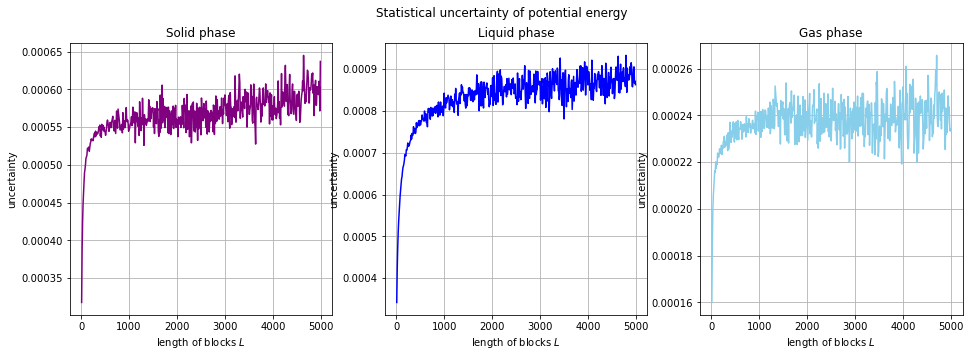

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Statistical uncertainty of potential energy')

ax1.plot(x,err_prog_s,color='purple')
ax1.set_xlabel('length of blocks $L$')
ax1.set_ylabel('uncertainty')
ax1.set_title('Solid phase')
ax1.grid(True)

ax2.plot(x,err_prog_l,color='blue')
ax2.set_xlabel('length of blocks $L$')
ax2.set_ylabel('uncertainty')
ax2.set_title('Liquid phase')
ax2.grid(True)

ax3.plot(x,err_prog_g,color='skyblue')
ax3.set_xlabel('length of blocks $L$')
ax3.set_ylabel('uncertainty')
ax3.set_title('Gas phase')
ax3.grid(True)

plt.show()

In all three cases the uncertainty seems to be underestimated for little $L$, as it starts growing rapidly, and then it converges to an almost constant value for larger $L$: we should then choose approximately $L>1000$ steps in order not to underestimate uncertainties, a point where they approximately reach a constant value and do not grow significantly anymore.

### Exercise 4

Here we are going to simulate a Lennard-Jones model of Argon in the solid, liquid and gas phase with the same thermodynamic conditions as the previous exercise. In particular, we are interested in the final estimation of the radial distribution function $g(r)$ that we have just added to the code (Exercise 3, only c++ code).

After equilibrating the system for all three phases, we are going to perform simulations both with Metropolis and Verlet algorithm and compare the two results; the Verlet algorithm has been used for the same system in Exercises 4.
<br> For the Verlet algorithm we are following the procedure described in Exercises 4: we have to start from a higher temperature, dependent on the phase of the system, in order to let it reach the requested value during the equilibration steps; the number of equilibration steps has been kept as it is in Exercises 4 for each phase.
<br> The equilibration steps required for the Metropolis sampling are the same as in exercise 2. Moreover, we can choose the length of the blocks according to the previous results: in our simulations we have considered 50 blocks of 2000 steps each.

Below we are plotting the results of our simulations for potential energy per particle, pressure and radial distribution function; as it is the main aim of the exercise, we are also plotting the absolute difference of this last quantity between the two simulations. 
<br> Kinetic energy and temperature are not considered in this exercise. Temperature is meant to be fixed for the Metropolis algorithm, which samples different configurations according to the Boltzmann weightz that need a certain value of temperature. With this structure of the algorithm the velocities are not computed, therefore the estimation of kinetic energy done in Exercises 4 has no meaning (it stays constant as the temperature is fixed).

#### Potential energy per particle:

In [2]:
# loading data
nblk = np.loadtxt("./ex_4/Output/Solid/Metropolis/output_epot.dat", usecols=(0), delimiter=None, unpack='true')

In [3]:
# Metropolis
# solid
epot_m_s, err_epot_m_s = np.loadtxt("./ex_4/Output/Solid/Metropolis/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
#liquid
epot_m_l, err_epot_m_l = np.loadtxt("./ex_4/Output/Liquid/Metropolis/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
#gas
epot_m_g, err_epot_m_g = np.loadtxt("./ex_4/Output/Gas/Metropolis/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')

# Verlet
# solid
epot_v_s, err_epot_v_s = np.loadtxt("./ex_4/Output/Solid/Verlet/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
#liquid
epot_v_l, err_epot_v_l = np.loadtxt("./ex_4/Output/Liquid/Verlet/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')
#gas
epot_v_g, err_epot_v_g = np.loadtxt("./ex_4/Output/Gas/Verlet/output_epot.dat", usecols=(2,3), delimiter=None, unpack='true')

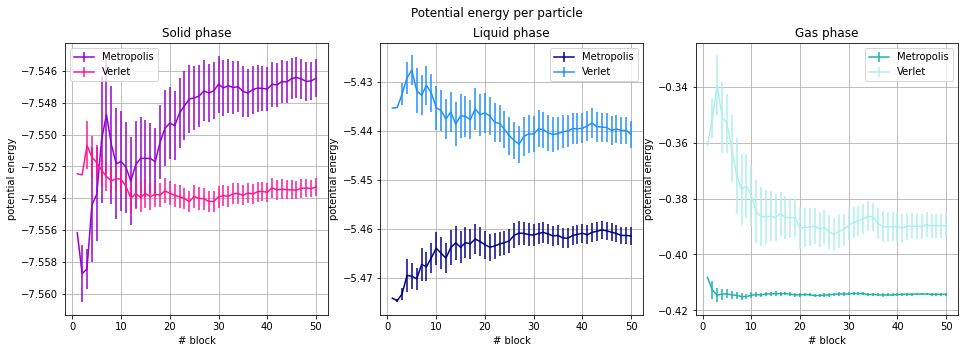

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Potential energy per particle')

ax1.errorbar(nblk,epot_m_s,yerr=err_epot_m_s,color='darkviolet',label='Metropolis')
ax1.errorbar(nblk,epot_v_s,yerr=err_epot_v_s,color='deeppink',label='Verlet')
ax1.set_xlabel('# block')
ax1.set_ylabel('potential energy')
ax1.set_title('Solid phase')
ax1.legend(loc='best')
ax1.grid(True)

ax2.errorbar(nblk,epot_m_l,yerr=err_epot_m_l,color='darkblue',label='Metropolis')
ax2.errorbar(nblk,epot_v_l,yerr=err_epot_v_l,color='dodgerblue',label='Verlet')
ax2.set_xlabel('# block')
ax2.set_ylabel('potential energy')
ax2.set_title('Liquid phase')
ax2.legend(loc='best')
ax2.grid(True)

ax3.errorbar(nblk,epot_m_g,yerr=err_epot_m_g,color='lightseagreen',label='Metropolis')
ax3.errorbar(nblk,epot_v_g,yerr=err_epot_v_g,color='paleturquoise',label='Verlet')
ax3.set_xlabel('# block')
ax3.set_ylabel('potential energy')
ax3.set_title('Gas phase')
ax3.legend(loc='best')
ax3.grid(True)

plt.show()

#### Pressure:

In [6]:
# Metropolis
# solid
press_m_s, err_press_m_s = np.loadtxt("./ex_4/Output/Solid/Metropolis/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
#liquid
press_m_l, err_press_m_l = np.loadtxt("./ex_4/Output/Liquid/Metropolis/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
#gas
press_m_g, err_press_m_g = np.loadtxt("./ex_4/Output/Gas/Metropolis/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')

# Verlet
# solid
press_v_s, err_press_v_s = np.loadtxt("./ex_4/Output/Solid/Verlet/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
#liquid
press_v_l, err_press_v_l = np.loadtxt("./ex_4/Output/Liquid/Verlet/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')
#gas
press_v_g, err_press_v_g = np.loadtxt("./ex_4/Output/Gas/Verlet/output_press.dat", usecols=(2,3), delimiter=None, unpack='true')

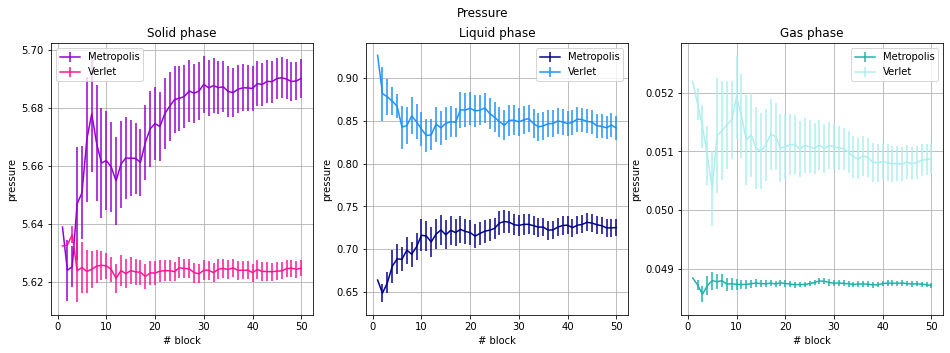

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Pressure')

ax1.errorbar(nblk,press_m_s,yerr=err_press_m_s,color='darkviolet',label='Metropolis')
ax1.errorbar(nblk,press_v_s,yerr=err_press_v_s,color='deeppink',label='Verlet')
ax1.set_xlabel('# block')
ax1.set_ylabel('pressure')
ax1.set_title('Solid phase')
ax1.legend(loc='best')
ax1.grid(True)

ax2.errorbar(nblk,press_m_l,yerr=err_press_m_l,color='darkblue',label='Metropolis')
ax2.errorbar(nblk,press_v_l,yerr=err_press_v_l,color='dodgerblue',label='Verlet')
ax2.set_xlabel('# block')
ax2.set_ylabel('pressure')
ax2.set_title('Liquid phase')
ax2.legend(loc='best')
ax2.grid(True)

ax3.errorbar(nblk,press_m_g,yerr=err_press_m_g,color='lightseagreen',label='Metropolis')
ax3.errorbar(nblk,press_v_g,yerr=err_press_v_g,color='paleturquoise',label='Verlet')
ax3.set_xlabel('# block')
ax3.set_ylabel('pressure')
ax3.set_title('Gas phase')
ax3.legend(loc='best')
ax3.grid(True)

plt.show()

#### Radial distribution function:

In [8]:
r = np.loadtxt("./ex_4/Output/Solid/Metropolis/output_gofr_final.dat", usecols=(0), delimiter=None, unpack='true')

# Metropolis
# solid
gofr_m_s = np.loadtxt("./ex_4/Output/Solid/Metropolis/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')
#liquid
gofr_m_l = np.loadtxt("./ex_4/Output/Liquid/Metropolis/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')
#gas
gofr_m_g = np.loadtxt("./ex_4/Output/Gas/Metropolis/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')

# Verlet
# solid
gofr_v_s = np.loadtxt("./ex_4/Output/Solid/Verlet/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')
#liquid
gofr_v_l = np.loadtxt("./ex_4/Output/Liquid/Verlet/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')
#gas
gofr_v_g = np.loadtxt("./ex_4/Output/Gas/Verlet/output_gofr_final.dat", usecols=(1), delimiter=None, unpack='true')

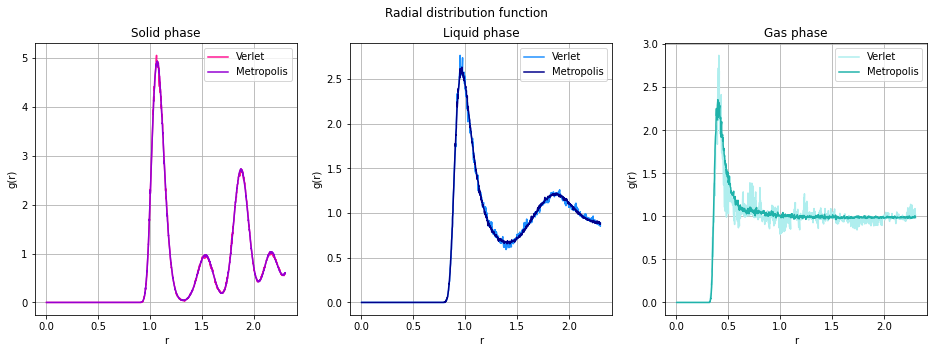

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Radial distribution function')

ax1.plot(r,gofr_v_s,color='deeppink',label='Verlet')
ax1.plot(r,gofr_m_s,color='darkviolet',label='Metropolis')
ax1.set_xlabel('r')
ax1.set_ylabel('g(r)')
ax1.set_title('Solid phase')
ax1.legend(loc='best')
ax1.grid(True)

ax2.plot(r,gofr_v_l,color='dodgerblue',label='Verlet')
ax2.plot(r,gofr_m_l,color='darkblue',label='Metropolis')
ax2.set_xlabel('r')
ax2.set_ylabel('g(r)')
ax2.set_title('Liquid phase')
ax2.legend(loc='best')
ax2.grid(True)

ax3.plot(r,gofr_v_g,color='paleturquoise',label='Verlet')
ax3.plot(r,gofr_m_g,color='lightseagreen',label='Metropolis')
ax3.set_xlabel('r')
ax3.set_ylabel('g(r)')
ax3.set_title('Gas phase')
ax3.legend(loc='best')
ax3.grid(True)

plt.show()

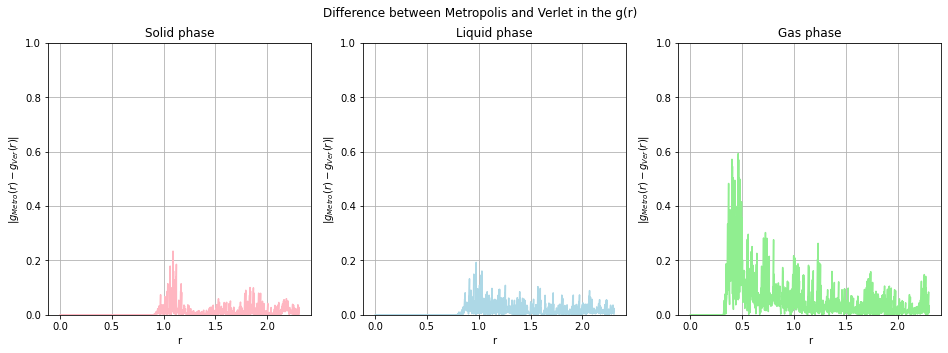

In [10]:
# plotting the difference of g(r) between Metropolis and Verlet

diff_solid = abs(gofr_m_s-gofr_v_s)
diff_liquid = abs(gofr_m_l-gofr_v_l)
diff_gas = abs(gofr_m_g-gofr_v_g)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
fig.suptitle('Difference between Metropolis and Verlet in the g(r)')

plt.setp((ax1,ax2,ax3), ylim=ax3.get_ylim())

ax1.plot(r,diff_solid,color='lightpink',label='diff_s')
ax1.set_xlabel('r')
ax1.set_ylabel(r'$|g_{Metro}(r)-g_{Ver}(r)|$')
ax1.set_title('Solid phase')
ax1.grid(True)

ax2.plot(r,diff_liquid,color='lightblue',label='diff_l')
ax2.set_xlabel('r')
ax2.set_ylabel(r'$|g_{Metro}(r)-g_{Ver}(r)|$')
ax2.set_title('Liquid phase')
ax2.grid(True)

ax3.plot(r,diff_gas,color='lightgreen',label='diff_g')
ax3.set_xlabel('r')
ax3.set_ylabel(r'$|g_{Metro}(r)-g_{Ver}(r)|$')
ax3.set_title('Gas phase')
ax3.grid(True)

plt.show()

Looking at these graphs we can conclude that the differences in the structure of the two algorithms (Metropolis and Verlet) are reflected in the behaviour of the measured quantities. 
<br> The fact that the two estimations of potential energy and pressure do not lay within the statistical errorbars of one another should not be concerning: both maintaining the number of particles and the density fixed, the Metropolis and the Verlet algorithms operate in a very different way, since the latter moves the system conserving the energy while the first one explores the surrounding configuration space following the Boltzmann probability distribution at fixed temperature. This results in a temperature change during the Verlet simulation (because of the change in kinetic energy that has to compensate that of potential energy to keep the energy constant) and in an energy change during the Metropolis simulation. Therefore the behaviour of potential energy and pressure, which are strongly connected to these features of the algorithms, is necessarily different in the two cases. 
<br> Anyway, the $g(r)$ plots suggest that with an adequate initial temperature for the Verlet algorithm we can reach a condition of comparability. Indeed, the two radial distribution functions have the same behaviour and mostly overlap in the solid and liquid phase, whereas they differ more in the gas phase, as we can see in particular from the last figure that directly shows the differences between the two cases. In all three cases the peaks appear in the same points, so the general trend of the functions can be considered statistically comparable. 